<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 9632, '日付': '2022-02-28T08:00:00.000Z'},
 {'小計': 11813, '日付': '2022-03-01T08:00:00.000Z'},
 {'小計': 12693, '日付': '2022-03-02T08:00:00.000Z'},
 {'小計': 12251, '日付': '2022-03-03T08:00:00.000Z'},
 {'小計': 10517, '日付': '2022-03-04T08:00:00.000Z'},
 {'小計': 10806, '日付': '2022-03-05T08:00:00.000Z'},
 {'小計': 9289, '日付': '2022-03-06T08:00:00.000Z'},
 {'小計': 5374, '日付': '2022-03-07T08:00:00.000Z'},
 {'小計': 8925, '日付': '2022-03-08T08:00:00.000Z'},
 {'小計': 10823, '日付': '2022-03-09T08:00:00.000Z'},
 {'小計': 10080, '日付': '2022-03-10T08:00:00.000Z'},
 {'小計': 8464, '日付': '2022-03-11T08:00:00.000Z'},
 {'小計': 9164, '日付': '2022-03-12T08:00:00.000Z'},
 {'小計': 8131, '日付': '2022-03-13T08:00:00.000Z'},
 {'小計': 4836, '日付': '2022-03-14T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-03-10 17:00:00+09:00,624,0,10080,2022-03-10 17:00:00+09:00
2022-03-11 17:00:00+09:00,639,0,8464,2022-03-11 17:00:00+09:00
2022-03-12 17:00:00+09:00,775,0,9164,2022-03-12 17:00:00+09:00
2022-03-13 17:00:00+09:00,621,0,8131,2022-03-13 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-03-10 17:00:00+09:00,624,0,10080,2022-03-10 17:00:00+09:00,743.000000,5201.0,0.0,0.0,9402.000000,65814.0
2022-03-11 17:00:00+09:00,639,0,8464,2022-03-11 17:00:00+09:00,728.857143,5102.0,0.0,0.0,9108.714286,63761.0
2022-03-12 17:00:00+09:00,775,0,9164,2022-03-12 17:00:00+09:00,708.285714,4958.0,0.0,0.0,8874.142857,62119.0
2022-03-13 17:00:00+09:00,621,0,8131,2022-03-13 17:00:00+09:00,701.571429,4911.0,0.0,0.0,8708.714286,60961.0
2022-03-14 17:00:00+09:00,0,0,4836,2022-03-14 17:00:00+09:00,577.571429,4043.0,0.0,0.0,8631.857143,60423.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-02-28 17:00:00+09:00,1013,0,9632,2022-02-28 17:00:00+09:00,1022.428571,7157.0,0.0,0.0,11259.857143,78819.0,'22w09,Mon
2022-03-01 17:00:00+09:00,899,0,11813,2022-03-01 17:00:00+09:00,1000.000000,7000.0,0.0,0.0,11312.714286,79189.0,'22w09,Tue
2022-03-02 17:00:00+09:00,834,0,12693,2022-03-02 17:00:00+09:00,960.714286,6725.0,0.0,0.0,11045.000000,77315.0,'22w09,Wed
2022-03-03 17:00:00+09:00,766,0,12251,2022-03-03 17:00:00+09:00,923.857143,6467.0,0.0,0.0,11342.428571,79397.0,'22w09,Thu
2022-03-04 17:00:00+09:00,738,0,10517,2022-03-04 17:00:00+09:00,894.142857,6259.0,0.0,0.0,11255.571429,78789.0,'22w09,Fri
2022-03-05 17:00:00+09:00,919,0,10806,2022-03-05 17:00:00+09:00,872.571429,6108.0,0.0,0.0,11147.571429,78033.0,'22w09,Sat
2022-03-06 17:00:00+09:00,668,0,9289,2022-03-06 17:00:00+09:00,833.857143,5837.0,0.0,0.0,11000.142857,77001.0,'22w09,Sun
2022-03-07 17:00:00+09:00,868,0,5374,2022-03-07 17:00:00+09:00,813.142857,5692.0,0.0,0.0,10391.857143,72743.0,'22w10,Mon
2022-03-08 17:00:00+09:00,695,0,8925,2022-03-08 17:00:00+09:00,784.000000,5488.0,0.0,0.0,9979.285714,69855.0,'22w10,Tue
2022-03-09 17:00:00+09:00,689,0,10823,2022-03-09 17:00:00+09:00,763.285714,5343.0,0.0,0.0,9712.142857,67985.0,'22w10,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-02-27 17:00:00+09:00,11141.714286,77992
2022-03-06 17:00:00+09:00,11000.142857,77001
2022-03-13 17:00:00+09:00,8708.714286,60961
2022-03-14 17:00:00+09:00,4836.000000,4836
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-02-28 17:00:00+09:00,1013,0,9632,2022-02-28 17:00:00+09:00,1022.428571,7157.0,0.0,0.0,11259.857143,78819.0,'22w09,Mon,NaN,NaN
2022-03-01 17:00:00+09:00,899,0,11813,2022-03-01 17:00:00+09:00,1000.000000,7000.0,0.0,0.0,11312.714286,79189.0,'22w09,Tue,NaN,NaN
2022-03-02 17:00:00+09:00,834,0,12693,2022-03-02 17:00:00+09:00,960.714286,6725.0,0.0,0.0,11045.000000,77315.0,'22w09,Wed,NaN,NaN
2022-03-03 17:00:00+09:00,766,0,12251,2022-03-03 17:00:00+09:00,923.857143,6467.0,0.0,0.0,11342.428571,79397.0,'22w09,Thu,NaN,NaN
2022-03-04 17:00:00+09:00,738,0,10517,2022-03-04 17:00:00+09:00,894.142857,6259.0,0.0,0.0,11255.571429,78789.0,'22w09,Fri,NaN,NaN
2022-03-05 17:00:00+09:00,919,0,10806,2022-03-05 17:00:00+09:00,872.571429,6108.0,0.0,0.0,11147.571429,78033.0,'22w09,Sat,NaN,NaN
2022-03-06 17:00:00+09:00,668,0,9289,2022-03-06 17:00:00+09:00,833.857143,5837.0,0.0,0.0,11000.142857,77001.0,'22w09,Sun,11000.142857,77001.0
2022-03-07 17:00:00+09:00,868,0,5374,2022-03-07 17:00:00+09:00,813.142857,5692.0,0.0,0.0,10391.857143,72743.0,'22w10,Mon,NaN,NaN
2022-03-08 17:00:00+09:00,695,0,8925,2022-03-08 17:00:00+09:00,784.000000,5488.0,0.0,0.0,9979.285714,69855.0,'22w10,Tue,NaN,NaN
2022-03-09 17:00:00+09:00,689,0,10823,2022-03-09 17:00:00+09:00,763.285714,5343.0,0.0,0.0,9712.142857,67985.0,'22w10,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

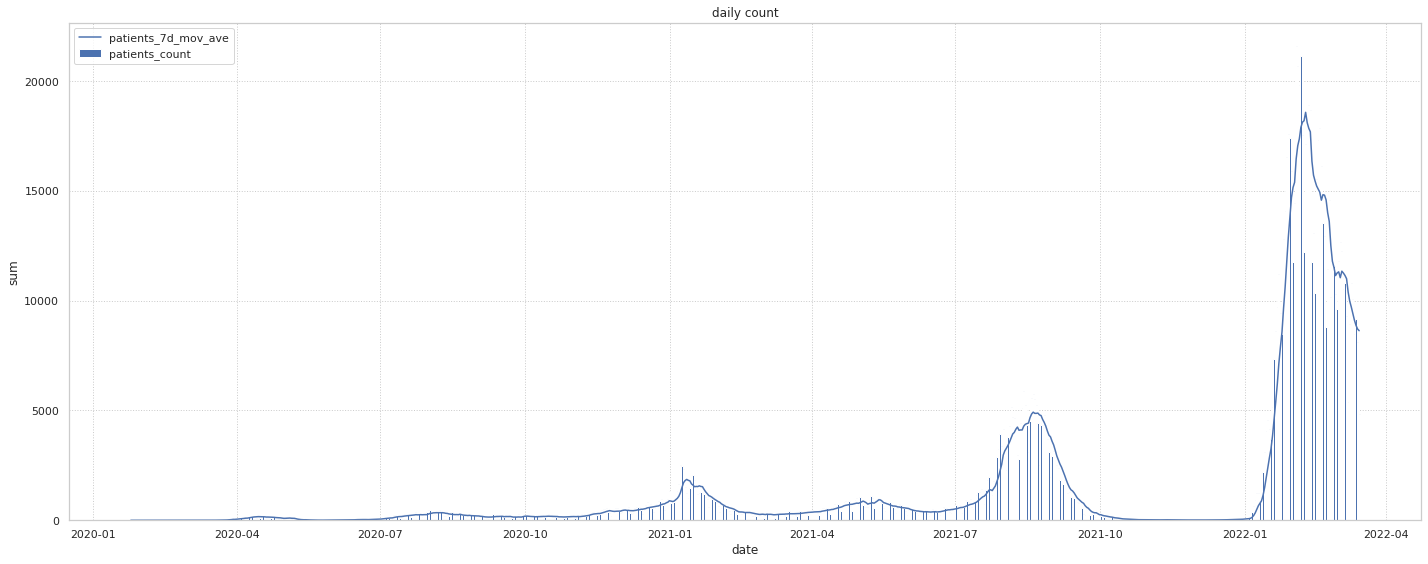

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
766,1.646035e+09,2022,2,28,0,1,0,0,0,0,...,692,1013,1022.428571,7157.0,0,0.0,0.0,9632,11259.857143,78819.0
767,1.646122e+09,2022,3,1,0,0,0,0,0,1,...,693,899,1000.000000,7000.0,0,0.0,0.0,11813,11312.714286,79189.0
768,1.646208e+09,2022,3,2,0,0,0,0,0,0,...,694,834,960.714286,6725.0,0,0.0,0.0,12693,11045.000000,77315.0
769,1.646294e+09,2022,3,3,0,0,0,0,1,0,...,695,766,923.857143,6467.0,0,0.0,0.0,12251,11342.428571,79397.0
770,1.646381e+09,2022,3,4,1,0,0,0,0,0,...,696,738,894.142857,6259.0,0,0.0,0.0,10517,11255.571429,78789.0
771,1.646467e+09,2022,3,5,0,0,1,0,0,0,...,697,919,872.571429,6108.0,0,0.0,0.0,10806,11147.571429,78033.0
772,1.646554e+09,2022,3,6,0,0,0,1,0,0,...,698,668,833.857143,5837.0,0,0.0,0.0,9289,11000.142857,77001.0
773,1.646640e+09,2022,3,7,0,1,0,0,0,0,...,699,868,813.142857,5692.0,0,0.0,0.0,5374,10391.857143,72743.0
774,1.646726e+09,2022,3,8,0,0,0,0,0,1,...,700,695,784.000000,5488.0,0,0.0,0.0,8925,9979.285714,69855.0
775,1.646813e+09,2022,3,9,0,0,0,0,0,0,...,701,689,763.285714,5343.0,0,0.0,0.0,10823,9712.142857,67985.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            781 non-null    float64
 1   year                 781 non-null    int64  
 2   month                781 non-null    int64  
 3   day                  781 non-null    int64  
 4   Fri                  781 non-null    uint8  
 5   Mon                  781 non-null    uint8  
 6   Sat                  781 non-null    uint8  
 7   Sun                  781 non-null    uint8  
 8   Thu                  781 non-null    uint8  
 9   Tue                  781 non-null    uint8  
 10  Wed                  781 non-null    uint8  
 11  passed               781 non-null    int64  
 12  emergency            781 non-null    int64  
 13  em_passed            781 non-null    int64  
 14  contacts_count       781 non-null    int64  
 15  contacts_7d_mov_ave  781 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.810000e+02,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,...,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,1.613549e+09,2020.654289,6.238156,15.667093,0.143406,0.143406,0.143406,0.143406,0.142125,0.142125,...,319.553137,689.381562,687.542314,4812.791293,471.855314,471.855314,3302.987196,1443.270166,1413.512402,9894.565941
std,1.949180e+07,0.643167,3.512925,8.832591,0.350711,0.350711,0.350711,0.350711,0.349403,0.349403,...,220.130337,560.894481,548.718174,3841.033345,780.940044,717.586002,5023.102013,3475.661509,3380.814045,23665.707046
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.596701e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,121.000000,327.000000,327.857143,2295.000000,0.000000,0.000000,0.000000,57.000000,55.142857,386.000000
50%,1.613549e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,316.000000,515.000000,517.857143,3625.000000,0.000000,0.000000,0.000000,268.000000,275.285714,1927.000000
75%,1.630397e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,511.000000,868.000000,888.142857,6217.000000,957.000000,1033.857143,7237.000000,736.000000,733.857143,5137.000000
max,1.647245e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,706.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21576.000000,18575.000000,130025.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.892048,0.150710,-0.015975,-0.002722,0.002722,-0.000907,0.000907,0.001805,-0.001805,...,0.998649,-0.017478,-0.006979,-0.006976,-0.618948,-0.664838,-0.664838,0.490976,0.495098,0.495099
year,8.920479e-01,1.000000,-0.310780,-0.057297,-0.001594,0.004090,0.004090,0.004090,-0.003572,-0.003572,...,0.897770,0.109029,0.119590,0.119591,-0.615451,-0.669788,-0.669788,0.615670,0.616317,0.616318
month,1.507099e-01,-0.310780,1.000000,0.009541,-0.002782,-0.003823,-0.011107,-0.007985,0.012079,0.004768,...,0.135221,-0.278190,-0.278134,-0.278131,0.046170,0.069567,0.069567,-0.315904,-0.308138,-0.308137
day,-1.597490e-02,-0.057297,0.009541,1.000000,0.006740,0.007154,0.002188,0.010879,-0.005005,-0.008744,...,-0.015666,0.020124,0.005496,0.005494,0.011371,0.001435,0.001435,-0.026007,-0.031936,-0.031937
Fri,-2.722245e-03,-0.001594,-0.002782,0.006740,1.000000,-0.167414,-0.167414,-0.167414,-0.166541,-0.166541,...,-0.002274,-0.015842,-0.001925,-0.001924,0.024595,-0.001030,-0.001030,0.017701,-0.000483,-0.000483
Mon,2.722245e-03,0.004090,-0.003823,0.007154,-0.167414,1.000000,-0.167414,-0.167414,-0.166541,-0.166541,...,0.002757,0.034355,-0.000596,-0.000595,0.100043,-0.001030,-0.001030,-0.054178,0.002935,0.002935
Sat,-9.074149e-04,0.004090,-0.011107,0.002188,-0.167414,-0.167414,1.000000,-0.167414,-0.166541,-0.166541,...,-0.000597,0.044496,-0.001187,-0.001186,-0.117520,-0.001030,-0.001030,0.013026,0.000933,0.000932
Sun,9.074149e-04,0.004090,-0.007985,0.010879,-0.167414,-0.167414,-0.167414,1.000000,-0.166541,-0.166541,...,0.001080,-0.023728,-0.000596,-0.000595,-0.108350,-0.001030,-0.001030,-0.010492,0.002188,0.002188
Thu,1.805361e-03,-0.003572,0.012079,-0.005005,-0.166541,-0.166541,-0.166541,-0.166541,1.000000,-0.165672,...,0.001360,-0.010836,0.002055,0.002056,0.030841,0.001379,0.001379,0.026433,-0.000264,-0.000263
Tue,-1.805361e-03,-0.003572,0.004768,-0.008744,-0.166541,-0.166541,-0.166541,-0.166541,-0.165672,1.000000,...,-0.002007,-0.016605,0.000801,0.000802,0.041709,0.001379,0.001379,-0.012138,-0.003504,-0.003504


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,1.646899e+09,0,0,0,0,1,0,0,776,0,702,624,0,10080,9402.000000,65814.0
777,1.646986e+09,1,0,0,0,0,0,0,777,0,703,639,0,8464,9108.714286,63761.0
778,1.647072e+09,0,0,1,0,0,0,0,778,0,704,775,0,9164,8874.142857,62119.0
779,1.647158e+09,0,0,0,1,0,0,0,779,0,705,621,0,8131,8708.714286,60961.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
776,1.646899e+09,776,0,10080,9402.000000,65814.0
777,1.646986e+09,777,0,8464,9108.714286,63761.0
778,1.647072e+09,778,0,9164,8874.142857,62119.0
779,1.647158e+09,779,0,8131,8708.714286,60961.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

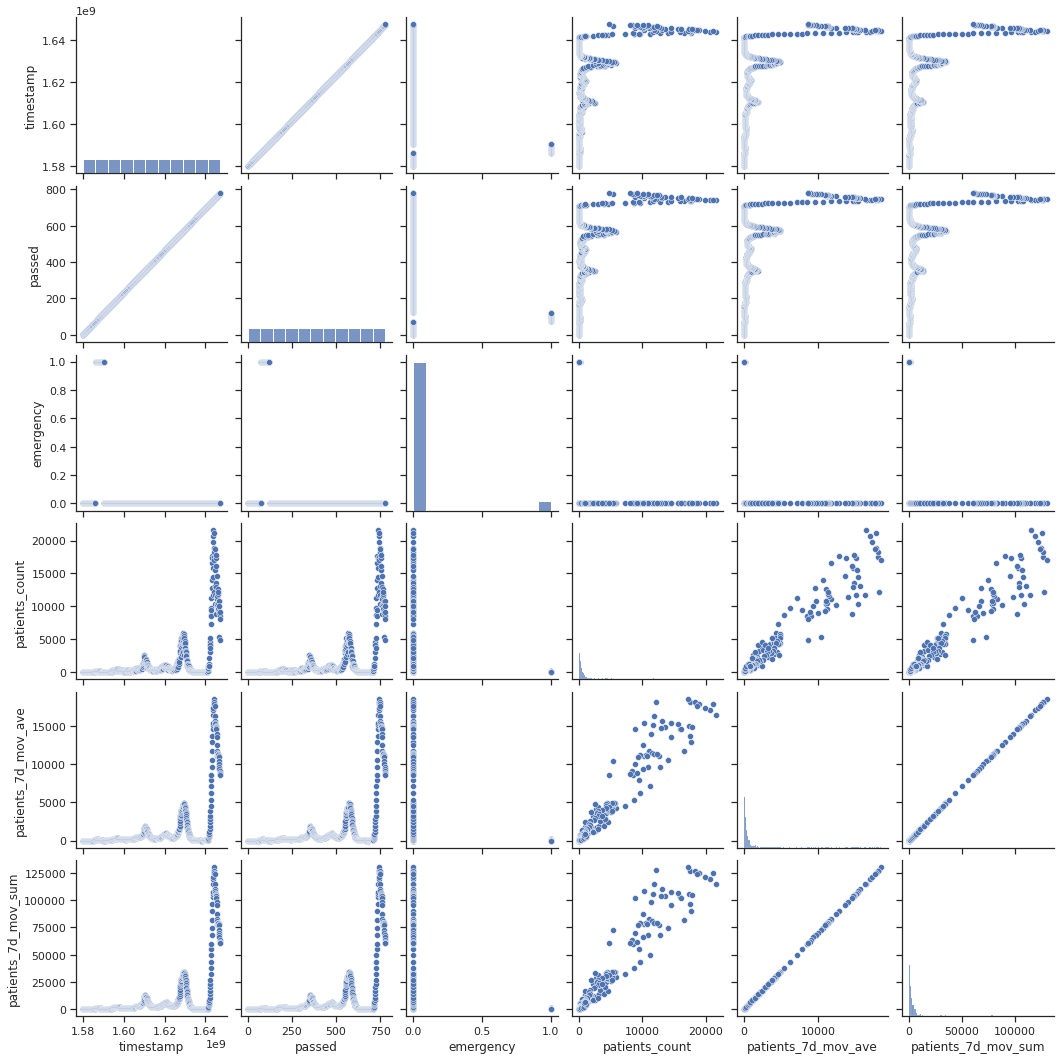

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==